In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df=pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/TRAIN_data.csv")

In [ ]:
df.shape

(109238, 12)

In [ ]:
df.sample(2)

,teacher_prefix,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,essay,year,price,teacher_number_of_previously_posted_projects,quantity,project_is_approved
32786,ms,va,grades_prek_2,music_thearts,music,music making whiteboard supplies,our school located in the washington d c area ...,2016,36.18,0,7,1
102131,teacher,nc,grades_3_5,health_sports,gym_fitness,volleyball for life,i teach at a title i school that is located ne...,2017,174.55,2,11,1


**splitting data into train and test data**

In [ ]:
y=df['project_is_approved'].values
x=df.drop(['project_is_approved'],axis=1)

In [ ]:
x.shape

(109238, 11)

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.30,stratify=y)

In [ ]:
x_train.shape, x_test.shape

((76466, 11), (32772, 11))

#Encoding categorical features to vectors using W2V

In [ ]:
x_train.columns

Index(['teacher_prefix', 'school_state', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'essay', 'year', 'price',
       'teacher_number_of_previously_posted_projects', 'quantity'],
      dtype='object')

In [ ]:
# this function returns train vectors,test vectors (CSR_Matrix),feature names, vocabulary
def get_vectorized(feat):
  count_vec=TfidfVectorizer()
  count_vec.fit(x_train[feat].values)
  train_vec=count_vec.transform(x_train[feat].values)
  test_vec=count_vec.transform(x_test[feat].values)
  return train_vec,test_vec,count_vec.get_feature_names(),count_vec.vocabulary_

**teacher_prefix**

In [ ]:
prefix_train,prefix_test,_,_=get_vectorized("teacher_prefix")

**school_state**

In [ ]:
state_train,state_test,_,_=get_vectorized("school_state")

**project_grade_category**

In [ ]:
grade_train,grade_test,_,_=get_vectorized("project_grade_category")

**project_subject_categories**

In [ ]:
categories_train,categories_test,_,_=get_vectorized("project_subject_categories")

**project_subject_subcategories**

In [ ]:
subcategories_train,subcategories_test,_,_=get_vectorized("project_subject_subcategories")

**year**

In [ ]:
year_train,year_test,_,_=get_vectorized("year")

#Encoding Text features to vectors

**essay and project_title**

In [ ]:
x_train['tit+ess']=x_train['project_title'].str.cat(x_train['essay'], sep=" ")

In [ ]:
x_test['tit+ess']=x_test['project_title'].str.cat(x_test['essay'], sep=" ")

In [ ]:
x_train.drop(['project_title','essay'],inplace=True,axis=1)
x_test.drop(['project_title','essay'],inplace=True,axis=1)

In [ ]:
vec=TfidfVectorizer(min_df=10,ngram_range=(1,4),stop_words='english',max_features=5000)
vec.fit(x_train['tit+ess'].values)
tit_ess_train=vec.transform(x_train['tit+ess'].values)
tit_ess_test=vec.transform(x_test['tit+ess'].values)

#Numerical features

In [ ]:
# this function helps to preprocess the numerical features, just pass the feature name to function as parameter
# and it will return you preprocessed train data and test data 
def get_preprocessed(feat):
  norm=Normalizer()
  norm.fit(x_train[feat].values.reshape(-1,1))
  train=norm.transform(x_train[feat].values.reshape(-1,1))
  test=norm.transform(x_test[feat].values.reshape(-1,1))
  return train,test

**price**

In [ ]:
price_train, price_test=get_preprocessed("price")

**teacher_number_of_previously_posted_projects**

In [ ]:
previously_train, previously_test=get_preprocessed("teacher_number_of_previously_posted_projects")

**quantity**

In [ ]:
quantity_train, quantity_test=get_preprocessed("quantity")

#Concatinating all features together 

In [ ]:
del x_train,x_test

In [ ]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
x_train=hstack((prefix_train, state_train, grade_train, categories_train, subcategories_train, year_train, 
                tit_ess_train, 
                price_train, previously_train)).tocsr()

x_test=hstack((prefix_test, state_test, grade_test, categories_test, subcategories_test, year_test, 
               tit_ess_test, 
                price_test, previously_test)).tocsr()
print(x_train.shape,x_test.shape)

(76466, 5103) (32772, 5103)


In [ ]:
del prefix_train, state_train, grade_train, categories_train, subcategories_train, year_train, tit_ess_train, price_train, previously_train
del prefix_test, state_test, grade_test, categories_test, subcategories_test, year_test, tit_ess_test, price_test, previously_test

# finding best hyperparameter for the model using random search cv

In [ ]:
NB=MultinomialNB(class_prior=[0.5,0.5])
params={'alpha':[0.01,0.1,0.5,1,5,10,50,100]}
random=RandomizedSearchCV(estimator=NB,param_distributions=params,cv=5,return_train_score=True,scoring="roc_auc",n_jobs=-1)
random.fit(x_train,y_train)

RandomizedSearchCV(cv=5, estimator=MultinomialNB(class_prior=[0.5, 0.5]),
                   n_jobs=-1,
                   param_distributions={'alpha': [0.01, 0.1, 0.5, 1, 5, 10, 50,
                                                  100]},
                   return_train_score=True, scoring='roc_auc')

In [ ]:
random.best_params_,random.best_score_

({'alpha': 0.01}, 0.6768358995885416)

In [ ]:
res=pd.DataFrame(random.cv_results_)
res=res.sort_values(['param_alpha'])
#res

In [ ]:
train_auc=res['mean_train_score']
cv_auc=res['mean_test_score']
alpha=res['param_alpha']

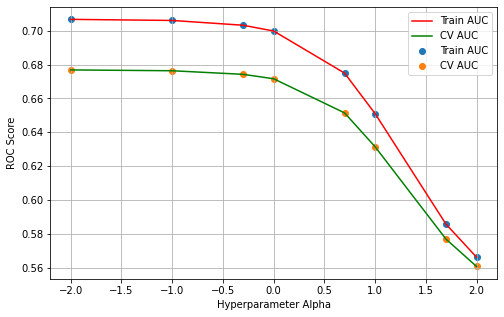

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(np.log10(alpha.tolist()), train_auc, label='Train AUC',color='red')
plt.plot(np.log10(alpha.tolist()), cv_auc, label='CV AUC',color='green')
plt.scatter(np.log10(alpha.tolist()), train_auc, label='Train AUC')
plt.scatter(np.log10(alpha.tolist()), cv_auc, label='CV AUC')
plt.xlabel("Hyperparameter Alpha")
plt.ylabel("ROC Score")
plt.grid()
plt.legend()
plt.show()

#Modeling our data

In [ ]:
from sklearn.metrics import roc_curve, auc

In [ ]:
NB=MultinomialNB(alpha=random.best_params_['alpha'],class_prior = [0.5,0.5])
NB.fit(x_train,y_train)
train_pred=NB.predict_proba(x_train)[:,1]
test_pred=NB.predict_proba(x_test)[:,1]


In [ ]:
y_pred=NB.predict(x_test)

In [ ]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train,train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test,test_pred)

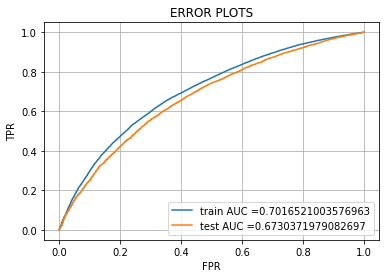

In [ ]:
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

#Confusion Matrix

In [ ]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

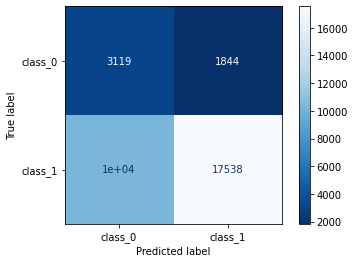

In [ ]:
plot_confusion_matrix(NB,x_test,y_test,cmap='Blues_r',display_labels=["class_0","class_1"])

In [ ]:
cf=confusion_matrix(y_test,y_pred)
cf

array([[ 3119,  1844],
       [10271, 17538]])

In [ ]:
right=((cf[0][0]+cf[1][1])/len(y_test))*100
error=((cf[0][1]+cf[1][0])/len(y_test))*100
print("Model is making right prediction on {}% datapoints".format(round(right)))
print()
print("Model is making error prediction on {}% datapoints".format(round(error)))

Model is making right prediction on 63% datapoints

Model is making error prediction on 37% datapoints


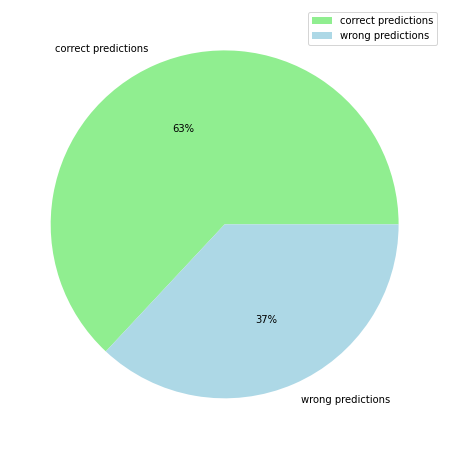

In [ ]:
data = [right,error]
labels = ["correct predictions","wrong predictions"]
colors=['lightgreen','lightblue']
#create pie chart
plt.figure(figsize=(8,8))
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.legend()
plt.show()
#-----------------------------------------------------------------------